In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc
import glob

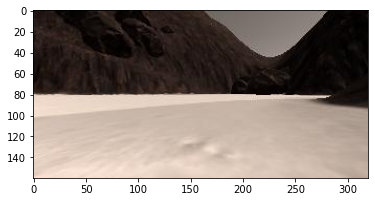

In [2]:
path = 'G:/handas/Digital project/Vision_Project_Startup_Code/Vision_Project_Startup_Code/test_dataset/IMG/*'
img_list = glob.glob(path)
idx = np.random.randint(0, len(img_list) - 1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

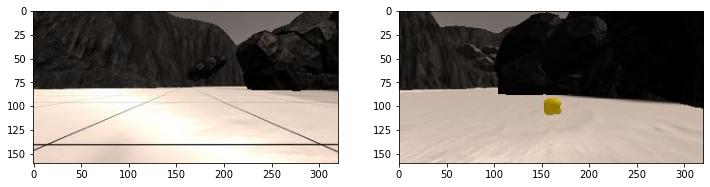

In [3]:
example_grid = 'G:/handas/Digital project/Vision_Project_Startup_Code/Vision_Project_Startup_Code/calibration_images/example_grid1.jpg'
example_rock = 'G:/handas/Digital project/Vision_Project_Startup_Code/Vision_Project_Startup_Code/calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)
fig = plt.figure(figsize = (12, 3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

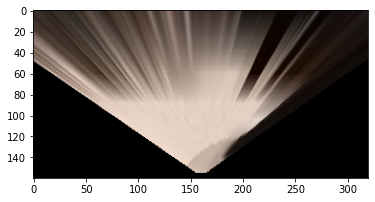

In [4]:
# define a function to perform a perspective transform
#using example grid image above to choose source points for the
#grid cell in front of the rover, each grid cell is 1 square meter in the rover_sim
def perspect_transform(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0])) #keep the size of input image
    return warped
#Defining calibration box in source (the real one) and destination (the desired one)coordinates
#The source and destination are defined to warp the image
#to a grid where each 10 x 10 pixel square represents 1 square meter
dst = 5
#set a bottom offset to compensate for the fact that the bottom of the image
#is not the position of the rover but a bit in front of it
bottom_offset = 6
source = np.float32([[14, 140],
                      [300, 140],
                      [200, 95],
                      [120, 95]])
destination = np.float32([[image.shape[1] / 2 - dst, image.shape[0] - bottom_offset],
                          [image.shape[1] / 2 + dst, image.shape[0] - bottom_offset],
                          [image.shape[1] / 2 + dst, image.shape[0] - 2*dst - bottom_offset],
                          [image.shape[1] / 2 - dst, image.shape[0] - 2*dst - bottom_offset]])
warped = perspect_transform(image, source, destination)
plt.imshow(warped)

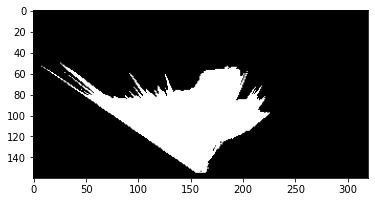

In [5]:
#identify pixels below the threshold
#threshold of RGB > 160 is fine for identifying ground pixels
def color_thresh(img, rgb_thresh = (160, 160, 160)):
    #Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:, :, 0])
    #require each pixel to be above all 3 threshold values in RGB
    #above_thresh will contain a boolean array with "True" when threshold is met
    above_thresh = (img[:, :, 0] > rgb_thresh[0]) \
                    &(img[:, :, 1] > rgb_thresh[1]) \
                    & (img[:, :, 2] > rgb_thresh[2])
    #index the array of zeros with boolean array and set to 1
    color_select[above_thresh] = 1
    #return binary image
    return color_select
threshed = color_thresh(warped)
plt.imshow(threshed, cmap = 'gray')


C:\Users\mosta\AppData\Local\Temp\ipykernel_472140\2919093366.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_pixel = -(ypos - width).astype(np.float)
C:\Users\mosta\AppData\Local\Temp\ipykernel_472140\2919093366.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pixel = -(xpos - height/2).astype(np.float)


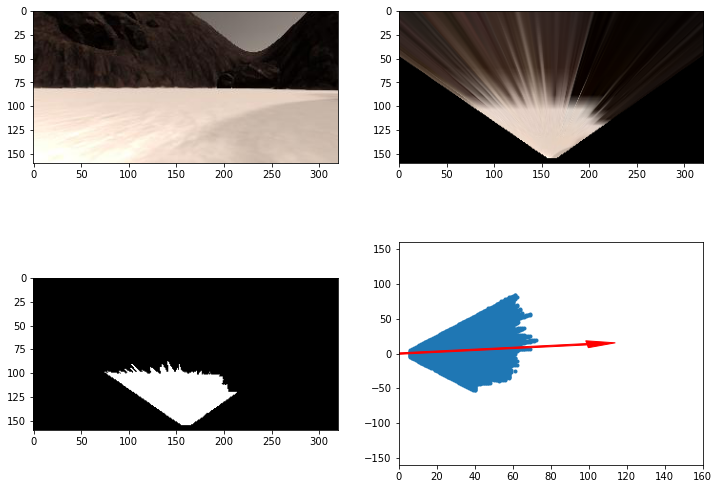

In [6]:
# defining a function to calculate distances and angles to all true pixels
def rover_coords(binary_img):
    #identify nonzero pixels
    #extract xpos and ypos pixel positions from binary_img and convert them to rover_centric coordinates
    ypos, xpos = binary_img.nonzero()
    width, height = binary_img.shape
    x_pixel = -(ypos - width).astype(np.float)
    y_pixel = -(xpos - height/2).astype(np.float)
    return x_pixel, y_pixel

def to_polar_coords(x_pixel, y_pixel):
    #covert (x_pixel, y_pixel) to (distance, angel)
    #in polar coordinates in rover space
    #calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 * y_pixel**2)
    #calculate angle using arctangent
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

#define a fucnction to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    #convert yaw to radians
    #apply a rotation
    #return the result
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    return xpix_rotated, ypix_rotated

#define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale):
    #apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    #return the result
    return xpix_translated, ypix_translated

def pix_to_world(dist, angles, x_rover, y_rover, yaw_rover):
    #map pixels from rover space to world coords
    pix_angles = angles + (yaw_rover * np.pi/180)
    x_pix_world = np.clip(np.int_((dist * np.sin(pix_angles)) + (x_rover)), 0, 499)
    y_pix_world = np.clip(np.int_((dist * np.cos(pix_angles)) + (y_rover)), 0, 499)
    return x_pix_world, y_pix_world



#grab another random image
idx = np.random.randint(0, len(img_list) - 1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

#calculate pixel values in rover.centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

#do some plotting
fig = plt.figure(figsize = (12, 9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap = 'gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color = 'red', zorder = 2, head_width=10, width =2)